# CH06
## RNN added gate

# 일반적인 RNN 성능이 그닥....
##  long term data를 기억하지 못함...
## LSTM이나 GRU를 사용!
## BPTT -> 장기간 데이터에서 기울기 소실 혹은 기울기 폭발 문제 발생 -> Relu로 활성화함수 대체하기도?

# 기울기 폭발

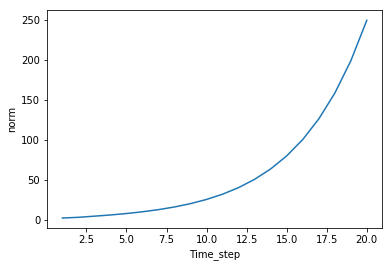

In [9]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차원의 수
T = 20 # 시계열 데이터

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh =np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
x = np.arange(1,21)
plt.plot(x,norm_list)
plt.xlabel("Time_step")
plt.ylabel("norm")
plt.show() # time step가 증가함에 따라 기울기가 지수적으로 증가함을 볼 수 있음 

# 기울기 감소

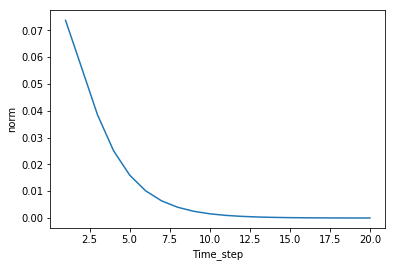

In [12]:
np.random.seed(3)
Wh = np.random.randn(H, H)* 0.5 # 변경후 

norm_list = []
for t in range(T):
    dh =np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
plt.plot(x, norm_list)
plt.xlabel("Time_step")
plt.ylabel("norm")
plt.show() # time step가 증가함에 따라 기울기가 감소함을 알 수 있음 

# 기울기 클리핑(기울기 폭발에 대한 대책)
## 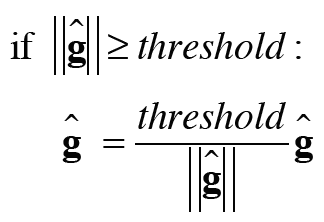

# 기울기 클리핑 구현 

In [14]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_num = 0
    for grad in grads:
        total_num += np.sum(grad**2)
    total_num = np.sqrt(total_num)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *=rate

# 기울기 소실에 대한 해결방안 -> LSTM
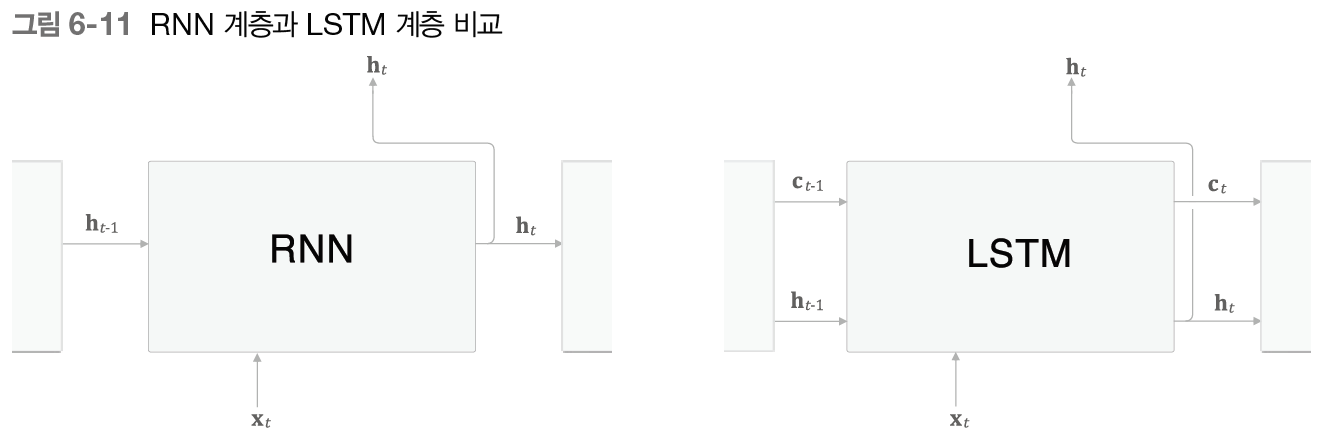

# LSTM gate -> data의 흐름을 제어함 (sigmoid 함수를 통해 내보낼 정보 비율을 계산 )

# output gate 
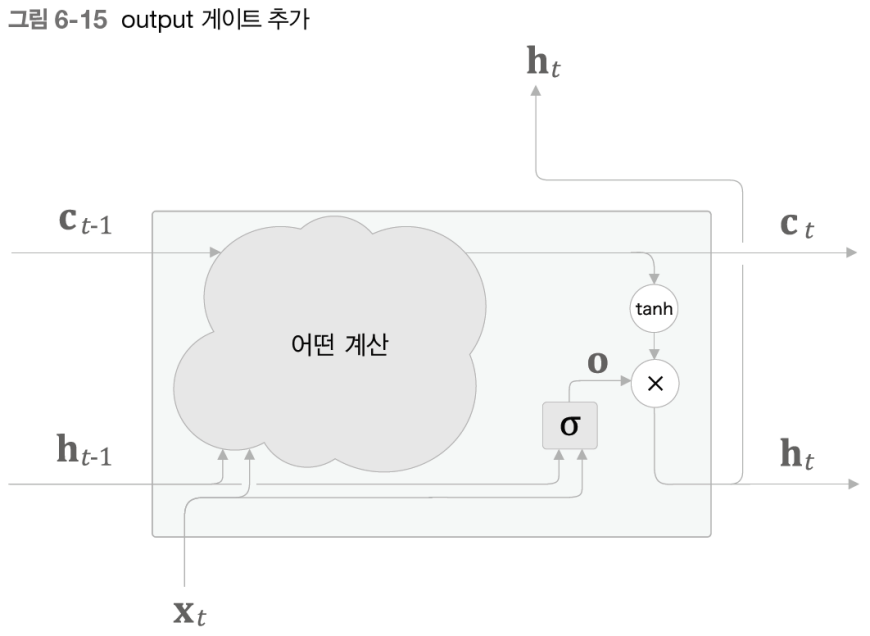

## gate 내부에서는 sigmoid, 출력에선 tanh 함수가 활성화 함수로 사용 

# forget gate 
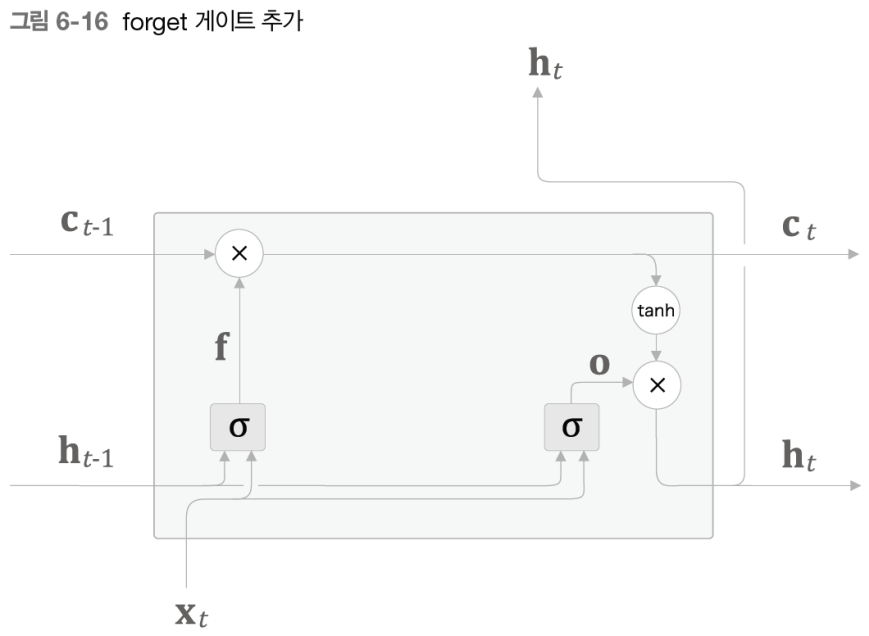



# LSTM 수식
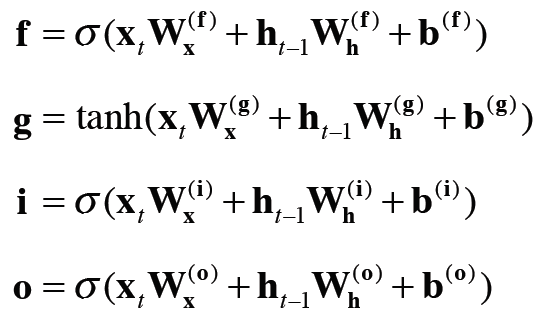

# LSTM class 구현

In [15]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

# 순전파

In [17]:
def forward(self, x, h_prev, C_prev):
    Wx, Wh, b = self.params
    N, H =h_prev.shape
    
    A = np.matmul(x, Wx) + np.matmul(h_prev, Wh)+ b
    
    #slice
    f = A[:, :H]
    g = A[:, H:2*H]
    i = A[:, 2*H:3*H]
    o = A[:, 3*H:]
    
    f = sigmoid(f)
    g = sigmoid(g)
    i = sigmoid(i)
    o = sigmoid(o)
    
    c_next = f * c_prev + g*i
    h_next = o*np.tanh(c_next)
    
    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next

In [19]:
dA = np.hstack((df, dg, di, do))

NameError: name 'df' is not defined

# TIME LSTM (T개의 시계열 데이터를 한번에 처리하는 계층)

In [25]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful = False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers =None
        self.h , self.c = None, None
        self.dh = None
        self.stateful = stateful
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H),dtype="f")
        
        if not self.stateful or self.h  is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None :
            self.c = np.zeros((N, H), dtype="f")
            
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self,h, self,c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        
        
        dxs = np.empty((N, T, D), dtype= "f")
        dh, dc = 0, 0
    
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t,:]+ dh, dc)
            dxs[:, t, :] = dx
        for i, grad in enumerate(layer.grads):
            grads[i] += grad
            
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            self.dh = dh
            return dxs
    
    def set_state(self, h, c=None):
        self.h, self.c = h, c
        
    def reset_state(self):
        self.h, self.c - None, None

In [29]:
import sys 
sys.path.append("..")
from common.time_layers import *
import pickle

class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size = 100, hidden_size = 100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.rand
        
        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype("f")
        lstm_Wx = (rn(D, 4*H)/ np.sqrt(D)).astype("f")
        lstm_Wh = (rn(H, 4 * H)/ np.sqrt(H)).astype("f")
        lstm_b = bo,zeros(4 * h).astype("f")
        affine_W = (rn(H, V)/ np.sqrt(H)).astype("f")
        affine_b = np.zeros(V).astype("f")
        
        # 계층 생성
        self.layers = [
        TimeEmbedding(embed_W),
        TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
        TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params , self.grads = [], []
        for layer in self.layers:
            self.params +=layer,params
            self.grads +=layer.grads
            
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    def backward(self, dout =1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    def reset_state(self):
        self.lstm_layer,reset_state()
        
    def save_params(self, file_name="Rnnlm.pkl"):
        with open(file_name, "wb") as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name="Rnnlm.pkl"):
        with open(file_name, "rb") as f:
            self.params = pickle.load(f)
        

Done
| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10001.07
| 에폭 1 |  반복 21 / 1327 | 시간 6[s] | 퍼플렉서티 2774.96
| 에폭 1 |  반복 41 / 1327 | 시간 12[s] | 퍼플렉서티 1206.39
| 에폭 1 |  반복 61 / 1327 | 시간 18[s] | 퍼플렉서티 938.64
| 에폭 1 |  반복 81 / 1327 | 시간 24[s] | 퍼플렉서티 813.80
| 에폭 1 |  반복 101 / 1327 | 시간 30[s] | 퍼플렉서티 661.31
| 에폭 1 |  반복 121 / 1327 | 시간 37[s] | 퍼플렉서티 621.13
| 에폭 1 |  반복 141 / 1327 | 시간 43[s] | 퍼플렉서티 591.04
| 에폭 1 |  반복 161 / 1327 | 시간 49[s] | 퍼플렉서티 574.19
| 에폭 1 |  반복 181 / 1327 | 시간 56[s] | 퍼플렉서티 581.22
| 에폭 1 |  반복 201 / 1327 | 시간 62[s] | 퍼플렉서티 496.57
| 에폭 1 |  반복 221 / 1327 | 시간 69[s] | 퍼플렉서티 488.71
| 에폭 1 |  반복 241 / 1327 | 시간 75[s] | 퍼플렉서티 441.98
| 에폭 1 |  반복 261 / 1327 | 시간 81[s] | 퍼플렉서티 468.02
| 에폭 1 |  반복 281 / 1327 | 시간 88[s] | 퍼플렉서티 454.83
| 에폭 1 |  반복 301 / 1327 | 시간 94[s] | 퍼플렉서티 380.29
| 에폭 1 |  반복 321 / 1327 | 시간 101[s] | 퍼플렉서티 350.96
| 에폭 1 |  반복 341 / 1327 | 시간 108[s] | 퍼플렉서티 393.01
| 에폭 1 |  반복 361 / 1327 | 시간 116[s] | 퍼플렉서티 400.10
| 에폭 1 |  반복 381 / 1327 | 시간 123[s] | 퍼플렉서티 32

| 에폭 3 |  반복 521 / 1327 | 시간 1184[s] | 퍼플렉서티 138.13
| 에폭 3 |  반복 541 / 1327 | 시간 1192[s] | 퍼플렉서티 137.94
| 에폭 3 |  반복 561 / 1327 | 시간 1200[s] | 퍼플렉서티 118.93
| 에폭 3 |  반복 581 / 1327 | 시간 1208[s] | 퍼플렉서티 106.29
| 에폭 3 |  반복 601 / 1327 | 시간 1215[s] | 퍼플렉서티 149.59
| 에폭 3 |  반복 621 / 1327 | 시간 1222[s] | 퍼플렉서티 143.60
| 에폭 3 |  반복 641 / 1327 | 시간 1229[s] | 퍼플렉서티 130.95
| 에폭 3 |  반복 661 / 1327 | 시간 1236[s] | 퍼플렉서티 120.81
| 에폭 3 |  반복 681 / 1327 | 시간 1243[s] | 퍼플렉서티 99.60
| 에폭 3 |  반복 701 / 1327 | 시간 1250[s] | 퍼플렉서티 119.56
| 에폭 3 |  반복 721 / 1327 | 시간 1259[s] | 퍼플렉서티 127.51
| 에폭 3 |  반복 741 / 1327 | 시간 1267[s] | 퍼플렉서티 108.13
| 에폭 3 |  반복 761 / 1327 | 시간 1276[s] | 퍼플렉서티 102.89
| 에폭 3 |  반복 781 / 1327 | 시간 1284[s] | 퍼플렉서티 104.51
| 에폭 3 |  반복 801 / 1327 | 시간 1292[s] | 퍼플렉서티 115.53
| 에폭 3 |  반복 821 / 1327 | 시간 1299[s] | 퍼플렉서티 116.57
| 에폭 3 |  반복 841 / 1327 | 시간 1306[s] | 퍼플렉서티 114.37
| 에폭 3 |  반복 861 / 1327 | 시간 1314[s] | 퍼플렉서티 120.82
| 에폭 3 |  반복 881 / 1327 | 시간 1322[s] | 퍼플렉서티 107.28
| 에폭 3 |  반복 

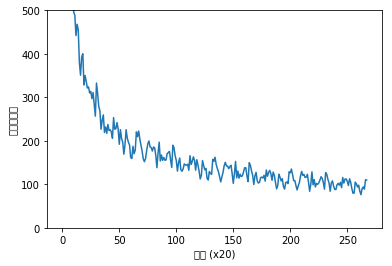

NameError: name 'eval_preplexity' is not defined

In [35]:
import sys 
sys.path.append("..")
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset2 import ptb
from rnnlm import Rnnlm

# 하이퍼파라미터 설정

batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습데이터 읽기

corpus, word_to_id, id_to_word = ptb.load_data("train")
corpus_test, _, _ = ptb.load_data("test")
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
           eval_interval = 20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print("test preplexity:", ppl_test)

model.save_params()

In [36]:
ppl_test = eval_perplexity(model, corpus_test)
print("test preplexity:", ppl_test)

model.save_params()

퍼플렉서티 평가 중 ...
234 / 235
test preplexity: 134.27172311379508


# 추가적으로 개선할 점이 많음 !

# RNNLM 개선 포인트
## 1. LSTM의 다층화
## 2. Dopout (overfitting 방지)
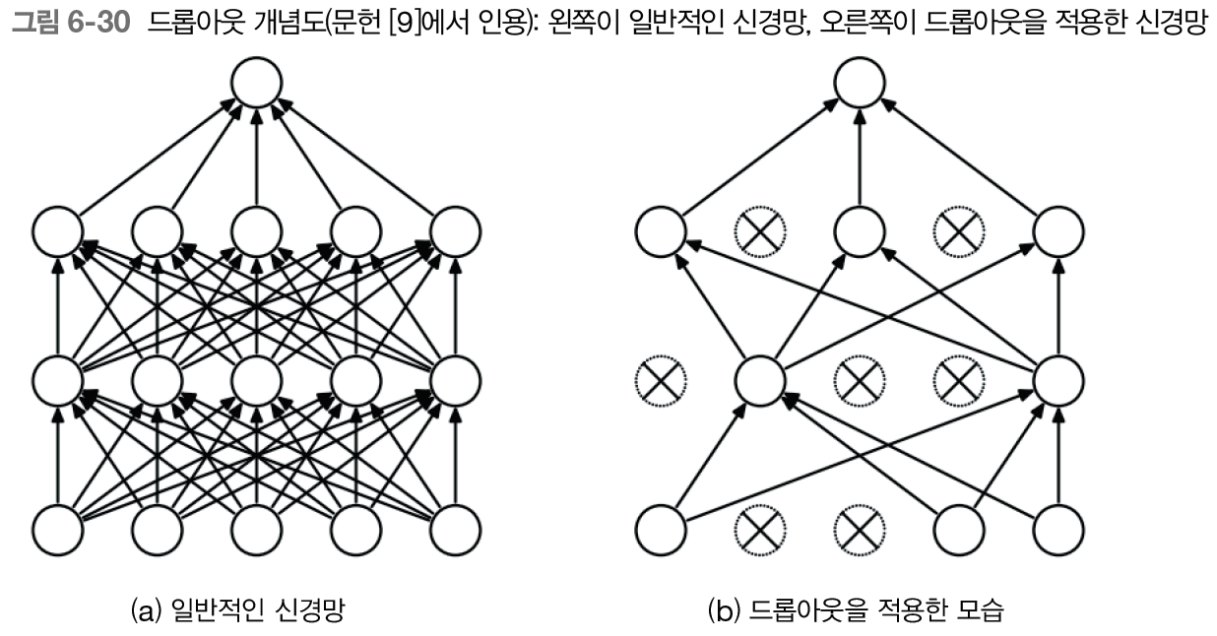
## LSTM 계층에선 좌우가 아닌 상하방향으로 Drop-out 진행 

## 3, 가중치 공유 
### Embedding과 Affine 계층의 가중치를 공유하는 방법 

#   RNN 개선 model

In [1]:
import sys
sys.path.append('..')
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset2 import ptb
from better_rnnlm import BetterRnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')



vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

| 에폭 1 |  반복 1 / 1327 | 시간 5[s] | 퍼플렉서티 9999.97
| 에폭 1 |  반복 21 / 1327 | 시간 80[s] | 퍼플렉서티 3896.99
| 에폭 1 |  반복 41 / 1327 | 시간 151[s] | 퍼플렉서티 1896.52
| 에폭 1 |  반복 61 / 1327 | 시간 221[s] | 퍼플렉서티 1357.00
| 에폭 1 |  반복 81 / 1327 | 시간 289[s] | 퍼플렉서티 986.56
| 에폭 1 |  반복 101 / 1327 | 시간 360[s] | 퍼플렉서티 849.84
| 에폭 1 |  반복 121 / 1327 | 시간 432[s] | 퍼플렉서티 791.78
| 에폭 1 |  반복 141 / 1327 | 시간 503[s] | 퍼플렉서티 725.15
| 에폭 1 |  반복 161 / 1327 | 시간 582[s] | 퍼플렉서티 692.79
| 에폭 1 |  반복 181 / 1327 | 시간 654[s] | 퍼플렉서티 689.68
| 에폭 1 |  반복 201 / 1327 | 시간 725[s] | 퍼플렉서티 607.90
| 에폭 1 |  반복 221 / 1327 | 시간 795[s] | 퍼플렉서티 577.64
| 에폭 1 |  반복 241 / 1327 | 시간 862[s] | 퍼플렉서티 519.43
| 에폭 1 |  반복 261 / 1327 | 시간 933[s] | 퍼플렉서티 533.22
| 에폭 1 |  반복 281 / 1327 | 시간 1001[s] | 퍼플렉서티 526.99
| 에폭 1 |  반복 301 / 1327 | 시간 1071[s] | 퍼플렉서티 452.55
| 에폭 1 |  반복 321 / 1327 | 시간 1140[s] | 퍼플렉서티 390.26
| 에폭 1 |  반복 341 / 1327 | 시간 1209[s] | 퍼플렉서티 458.64
| 에폭 1 |  반복 361 / 1327 | 시간 1278[s] | 퍼플렉서티 459.41
| 에폭 1 |  반복 381 / 1327 | 시간 13

| 에폭 3 |  반복 421 / 1327 | 시간 1563[s] | 퍼플렉서티 131.08
| 에폭 3 |  반복 441 / 1327 | 시간 1639[s] | 퍼플렉서티 138.94
| 에폭 3 |  반복 461 / 1327 | 시간 1715[s] | 퍼플렉서티 138.16
| 에폭 3 |  반복 481 / 1327 | 시간 1784[s] | 퍼플렉서티 133.81
| 에폭 3 |  반복 501 / 1327 | 시간 1857[s] | 퍼플렉서티 150.32
| 에폭 3 |  반복 521 / 1327 | 시간 1932[s] | 퍼플렉서티 150.86
| 에폭 3 |  반복 541 / 1327 | 시간 2004[s] | 퍼플렉서티 158.78
| 에폭 3 |  반복 561 / 1327 | 시간 2075[s] | 퍼플렉서티 132.95
| 에폭 3 |  반복 581 / 1327 | 시간 2151[s] | 퍼플렉서티 121.87
| 에폭 3 |  반복 601 / 1327 | 시간 2223[s] | 퍼플렉서티 170.76
| 에폭 3 |  반복 621 / 1327 | 시간 2294[s] | 퍼플렉서티 160.25
| 에폭 3 |  반복 641 / 1327 | 시간 2370[s] | 퍼플렉서티 146.01
| 에폭 3 |  반복 661 / 1327 | 시간 2442[s] | 퍼플렉서티 135.72
| 에폭 3 |  반복 681 / 1327 | 시간 2513[s] | 퍼플렉서티 115.88
| 에폭 3 |  반복 701 / 1327 | 시간 2588[s] | 퍼플렉서티 137.97
| 에폭 3 |  반복 721 / 1327 | 시간 2661[s] | 퍼플렉서티 139.58
| 에폭 3 |  반복 741 / 1327 | 시간 2731[s] | 퍼플렉서티 119.72
| 에폭 3 |  반복 761 / 1327 | 시간 2806[s] | 퍼플렉서티 113.63
| 에폭 3 |  반복 781 / 1327 | 시간 2880[s] | 퍼플렉서티 119.17
| 에폭 3 |  반복

| 에폭 5 |  반복 841 / 1327 | 시간 2991[s] | 퍼플렉서티 104.46
| 에폭 5 |  반복 861 / 1327 | 시간 3059[s] | 퍼플렉서티 103.67
| 에폭 5 |  반복 881 / 1327 | 시간 3131[s] | 퍼플렉서티 93.65
| 에폭 5 |  반복 901 / 1327 | 시간 3205[s] | 퍼플렉서티 120.93
| 에폭 5 |  반복 921 / 1327 | 시간 3274[s] | 퍼플렉서티 104.30
| 에폭 5 |  반복 941 / 1327 | 시간 3345[s] | 퍼플렉서티 111.37
| 에폭 5 |  반복 961 / 1327 | 시간 3421[s] | 퍼플렉서티 120.43
| 에폭 5 |  반복 981 / 1327 | 시간 3493[s] | 퍼플렉서티 113.20
| 에폭 5 |  반복 1001 / 1327 | 시간 3561[s] | 퍼플렉서티 98.92
| 에폭 5 |  반복 1021 / 1327 | 시간 3633[s] | 퍼플렉서티 117.73
| 에폭 5 |  반복 1041 / 1327 | 시간 3706[s] | 퍼플렉서티 100.47
| 에폭 5 |  반복 1061 / 1327 | 시간 3776[s] | 퍼플렉서티 95.78
| 에폭 5 |  반복 1081 / 1327 | 시간 3845[s] | 퍼플렉서티 79.14
| 에폭 5 |  반복 1101 / 1327 | 시간 3920[s] | 퍼플렉서티 81.55
| 에폭 5 |  반복 1121 / 1327 | 시간 3990[s] | 퍼플렉서티 109.42
| 에폭 5 |  반복 1141 / 1327 | 시간 4059[s] | 퍼플렉서티 106.85
| 에폭 5 |  반복 1161 / 1327 | 시간 4133[s] | 퍼플렉서티 90.41
| 에폭 5 |  반복 1181 / 1327 | 시간 4202[s] | 퍼플렉서티 98.63
| 에폭 5 |  반복 1201 / 1327 | 시간 4272[s] | 퍼플렉서티 81.37
| 에폭 5 | 

| 에폭 7 |  반복 1281 / 1327 | 시간 4514[s] | 퍼플렉서티 79.74
| 에폭 7 |  반복 1301 / 1327 | 시간 4585[s] | 퍼플렉서티 102.42
| 에폭 7 |  반복 1321 / 1327 | 시간 4654[s] | 퍼플렉서티 101.60
퍼플렉서티 평가 중 ...
209 / 210
검증 퍼플렉서티:  96.58773244929661
--------------------------------------------------
| 에폭 8 |  반복 1 / 1327 | 시간 3[s] | 퍼플렉서티 141.50
| 에폭 8 |  반복 21 / 1327 | 시간 77[s] | 퍼플렉서티 88.98
| 에폭 8 |  반복 41 / 1327 | 시간 144[s] | 퍼플렉서티 85.53
| 에폭 8 |  반복 61 / 1327 | 시간 218[s] | 퍼플렉서티 83.12
| 에폭 8 |  반복 81 / 1327 | 시간 288[s] | 퍼플렉서티 73.72
| 에폭 8 |  반복 101 / 1327 | 시간 356[s] | 퍼플렉서티 71.09
| 에폭 8 |  반복 121 / 1327 | 시간 429[s] | 퍼플렉서티 77.63
| 에폭 8 |  반복 141 / 1327 | 시간 499[s] | 퍼플렉서티 82.80
| 에폭 8 |  반복 161 / 1327 | 시간 568[s] | 퍼플렉서티 96.67
| 에폭 8 |  반복 181 / 1327 | 시간 640[s] | 퍼플렉서티 105.00
| 에폭 8 |  반복 201 / 1327 | 시간 712[s] | 퍼플렉서티 101.60
| 에폭 8 |  반복 221 / 1327 | 시간 780[s] | 퍼플렉서티 98.35
| 에폭 8 |  반복 241 / 1327 | 시간 850[s] | 퍼플렉서티 92.92
| 에폭 8 |  반복 261 / 1327 | 시간 923[s] | 퍼플렉서티 99.25
| 에폭 8 |  반복 281 / 1327 | 시간 991[s] | 퍼플렉서티

| 에폭 10 |  반복 361 / 1327 | 시간 1271[s] | 퍼플렉서티 86.86
| 에폭 10 |  반복 381 / 1327 | 시간 1345[s] | 퍼플렉서티 74.19
| 에폭 10 |  반복 401 / 1327 | 시간 1411[s] | 퍼플렉서티 83.92
| 에폭 10 |  반복 421 / 1327 | 시간 1484[s] | 퍼플렉서티 71.45
| 에폭 10 |  반복 441 / 1327 | 시간 1556[s] | 퍼플렉서티 77.80
| 에폭 10 |  반복 461 / 1327 | 시간 1624[s] | 퍼플렉서티 77.17
| 에폭 10 |  반복 481 / 1327 | 시간 1695[s] | 퍼플렉서티 76.63
| 에폭 10 |  반복 501 / 1327 | 시간 1768[s] | 퍼플렉서티 84.83
| 에폭 10 |  반복 521 / 1327 | 시간 1834[s] | 퍼플렉서티 88.11
| 에폭 10 |  반복 541 / 1327 | 시간 1906[s] | 퍼플렉서티 89.30
| 에폭 10 |  반복 561 / 1327 | 시간 1978[s] | 퍼플렉서티 74.08
| 에폭 10 |  반복 581 / 1327 | 시간 2047[s] | 퍼플렉서티 69.20
| 에폭 10 |  반복 601 / 1327 | 시간 2118[s] | 퍼플렉서티 96.78
| 에폭 10 |  반복 621 / 1327 | 시간 2191[s] | 퍼플렉서티 92.47
| 에폭 10 |  반복 641 / 1327 | 시간 2263[s] | 퍼플렉서티 82.82
| 에폭 10 |  반복 661 / 1327 | 시간 2332[s] | 퍼플렉서티 78.06
| 에폭 10 |  반복 681 / 1327 | 시간 2406[s] | 퍼플렉서티 66.88
| 에폭 10 |  반복 701 / 1327 | 시간 2474[s] | 퍼플렉서티 78.15
| 에폭 10 |  반복 721 / 1327 | 시간 2544[s] | 퍼플렉서티 79.36
| 에폭 10 |  반

| 에폭 12 |  반복 761 / 1327 | 시간 2871[s] | 퍼플렉서티 59.41
| 에폭 12 |  반복 781 / 1327 | 시간 2946[s] | 퍼플렉서티 66.04
| 에폭 12 |  반복 801 / 1327 | 시간 3018[s] | 퍼플렉서티 75.38
| 에폭 12 |  반복 821 / 1327 | 시간 3096[s] | 퍼플렉서티 74.15
| 에폭 12 |  반복 841 / 1327 | 시간 3181[s] | 퍼플렉서티 74.26
| 에폭 12 |  반복 861 / 1327 | 시간 3251[s] | 퍼플렉서티 73.59
| 에폭 12 |  반복 881 / 1327 | 시간 3328[s] | 퍼플렉서티 68.16
| 에폭 12 |  반복 901 / 1327 | 시간 3408[s] | 퍼플렉서티 85.00
| 에폭 12 |  반복 921 / 1327 | 시간 3478[s] | 퍼플렉서티 76.34
| 에폭 12 |  반복 941 / 1327 | 시간 3557[s] | 퍼플렉서티 81.05
| 에폭 12 |  반복 961 / 1327 | 시간 3635[s] | 퍼플렉서티 86.13
| 에폭 12 |  반복 981 / 1327 | 시간 3705[s] | 퍼플렉서티 82.31
| 에폭 12 |  반복 1001 / 1327 | 시간 3782[s] | 퍼플렉서티 70.92
| 에폭 12 |  반복 1021 / 1327 | 시간 3861[s] | 퍼플렉서티 82.43
| 에폭 12 |  반복 1041 / 1327 | 시간 3932[s] | 퍼플렉서티 71.86
| 에폭 12 |  반복 1061 / 1327 | 시간 4009[s] | 퍼플렉서티 68.32
| 에폭 12 |  반복 1081 / 1327 | 시간 4089[s] | 퍼플렉서티 55.65
| 에폭 12 |  반복 1101 / 1327 | 시간 4159[s] | 퍼플렉서티 56.65
| 에폭 12 |  반복 1121 / 1327 | 시간 4235[s] | 퍼플렉서티 77.80
| 에폭 

| 에폭 14 |  반복 1161 / 1327 | 시간 4482[s] | 퍼플렉서티 59.98
| 에폭 14 |  반복 1181 / 1327 | 시간 4555[s] | 퍼플렉서티 68.19
| 에폭 14 |  반복 1201 / 1327 | 시간 4634[s] | 퍼플렉서티 56.00
| 에폭 14 |  반복 1221 / 1327 | 시간 4708[s] | 퍼플렉서티 55.87
| 에폭 14 |  반복 1241 / 1327 | 시간 4781[s] | 퍼플렉서티 67.62
| 에폭 14 |  반복 1261 / 1327 | 시간 4861[s] | 퍼플렉서티 64.14
| 에폭 14 |  반복 1281 / 1327 | 시간 4936[s] | 퍼플렉서티 64.79
| 에폭 14 |  반복 1301 / 1327 | 시간 5008[s] | 퍼플렉서티 80.85
| 에폭 14 |  반복 1321 / 1327 | 시간 5086[s] | 퍼플렉서티 78.86
퍼플렉서티 평가 중 ...
209 / 210
검증 퍼플렉서티:  88.1243225172285
--------------------------------------------------
| 에폭 15 |  반복 1 / 1327 | 시간 3[s] | 퍼플렉서티 121.72
| 에폭 15 |  반복 21 / 1327 | 시간 77[s] | 퍼플렉서티 70.74
| 에폭 15 |  반복 41 / 1327 | 시간 151[s] | 퍼플렉서티 67.90
| 에폭 15 |  반복 61 / 1327 | 시간 230[s] | 퍼플렉서티 66.14
| 에폭 15 |  반복 81 / 1327 | 시간 304[s] | 퍼플렉서티 57.85
| 에폭 15 |  반복 101 / 1327 | 시간 376[s] | 퍼플렉서티 55.51
| 에폭 15 |  반복 121 / 1327 | 시간 453[s] | 퍼플렉서티 59.87
| 에폭 15 |  반복 141 / 1327 | 시간 527[s] | 퍼플렉서티 64.48
| 에폭 15 |  반복 161 /

| 에폭 17 |  반복 181 / 1327 | 시간 672[s] | 퍼플렉서티 78.64
| 에폭 17 |  반복 201 / 1327 | 시간 748[s] | 퍼플렉서티 76.05
| 에폭 17 |  반복 221 / 1327 | 시간 821[s] | 퍼플렉서티 74.30
| 에폭 17 |  반복 241 / 1327 | 시간 895[s] | 퍼플렉서티 69.62
| 에폭 17 |  반복 261 / 1327 | 시간 974[s] | 퍼플렉서티 74.49
| 에폭 17 |  반복 281 / 1327 | 시간 1044[s] | 퍼플렉서티 73.10
| 에폭 17 |  반복 301 / 1327 | 시간 1119[s] | 퍼플렉서티 59.07
| 에폭 17 |  반복 321 / 1327 | 시간 1197[s] | 퍼플렉서티 49.32
| 에폭 17 |  반복 341 / 1327 | 시간 1266[s] | 퍼플렉서티 70.44
| 에폭 17 |  반복 361 / 1327 | 시간 1346[s] | 퍼플렉서티 72.25
| 에폭 17 |  반복 381 / 1327 | 시간 1423[s] | 퍼플렉서티 61.03
| 에폭 17 |  반복 401 / 1327 | 시간 1496[s] | 퍼플렉서티 69.99
| 에폭 17 |  반복 421 / 1327 | 시간 1569[s] | 퍼플렉서티 59.06
| 에폭 17 |  반복 441 / 1327 | 시간 1648[s] | 퍼플렉서티 63.77
| 에폭 17 |  반복 461 / 1327 | 시간 1725[s] | 퍼플렉서티 63.40
| 에폭 17 |  반복 481 / 1327 | 시간 1794[s] | 퍼플렉서티 63.53
| 에폭 17 |  반복 501 / 1327 | 시간 1872[s] | 퍼플렉서티 70.00
| 에폭 17 |  반복 521 / 1327 | 시간 1944[s] | 퍼플렉서티 72.96
| 에폭 17 |  반복 541 / 1327 | 시간 2017[s] | 퍼플렉서티 73.03
| 에폭 17 |  반복 561

| 에폭 19 |  반복 581 / 1327 | 시간 2166[s] | 퍼플렉서티 56.35
| 에폭 19 |  반복 601 / 1327 | 시간 2243[s] | 퍼플렉서티 79.17
| 에폭 19 |  반복 621 / 1327 | 시간 2319[s] | 퍼플렉서티 73.18
| 에폭 19 |  반복 641 / 1327 | 시간 2391[s] | 퍼플렉서티 67.06
| 에폭 19 |  반복 661 / 1327 | 시간 2464[s] | 퍼플렉서티 61.35
| 에폭 19 |  반복 681 / 1327 | 시간 2540[s] | 퍼플렉서티 54.58
| 에폭 19 |  반복 701 / 1327 | 시간 2616[s] | 퍼플렉서티 63.81
| 에폭 19 |  반복 721 / 1327 | 시간 2688[s] | 퍼플렉서티 64.92
| 에폭 19 |  반복 741 / 1327 | 시간 2765[s] | 퍼플렉서티 56.80
| 에폭 19 |  반복 761 / 1327 | 시간 2841[s] | 퍼플렉서티 51.37
| 에폭 19 |  반복 781 / 1327 | 시간 2911[s] | 퍼플렉서티 57.39
| 에폭 19 |  반복 801 / 1327 | 시간 2989[s] | 퍼플렉서티 63.88
| 에폭 19 |  반복 821 / 1327 | 시간 3063[s] | 퍼플렉서티 64.20
| 에폭 19 |  반복 841 / 1327 | 시간 3135[s] | 퍼플렉서티 64.02
| 에폭 19 |  반복 861 / 1327 | 시간 3213[s] | 퍼플렉서티 64.21
| 에폭 19 |  반복 881 / 1327 | 시간 3284[s] | 퍼플렉서티 57.85
| 에폭 19 |  반복 901 / 1327 | 시간 3358[s] | 퍼플렉서티 74.34
| 에폭 19 |  반복 921 / 1327 | 시간 3439[s] | 퍼플렉서티 66.05
| 에폭 19 |  반복 941 / 1327 | 시간 3510[s] | 퍼플렉서티 71.08
| 에폭 19 |  반

| 에폭 21 |  반복 981 / 1327 | 시간 3623[s] | 퍼플렉서티 57.45
| 에폭 21 |  반복 1001 / 1327 | 시간 3698[s] | 퍼플렉서티 49.48
| 에폭 21 |  반복 1021 / 1327 | 시간 3772[s] | 퍼플렉서티 57.58
| 에폭 21 |  반복 1041 / 1327 | 시간 3842[s] | 퍼플렉서티 50.17
| 에폭 21 |  반복 1061 / 1327 | 시간 3918[s] | 퍼플렉서티 47.33
| 에폭 21 |  반복 1081 / 1327 | 시간 3989[s] | 퍼플렉서티 38.93
| 에폭 21 |  반복 1101 / 1327 | 시간 4062[s] | 퍼플렉서티 39.59
| 에폭 21 |  반복 1121 / 1327 | 시간 4138[s] | 퍼플렉서티 54.16
| 에폭 21 |  반복 1141 / 1327 | 시간 4209[s] | 퍼플렉서티 52.01
| 에폭 21 |  반복 1161 / 1327 | 시간 4280[s] | 퍼플렉서티 43.54
| 에폭 21 |  반복 1181 / 1327 | 시간 4356[s] | 퍼플렉서티 49.21
| 에폭 21 |  반복 1201 / 1327 | 시간 4427[s] | 퍼플렉서티 40.43
| 에폭 21 |  반복 1221 / 1327 | 시간 4499[s] | 퍼플렉서티 39.64
| 에폭 21 |  반복 1241 / 1327 | 시간 4576[s] | 퍼플렉서티 48.41
| 에폭 21 |  반복 1261 / 1327 | 시간 4646[s] | 퍼플렉서티 46.95
| 에폭 21 |  반복 1281 / 1327 | 시간 4719[s] | 퍼플렉서티 46.86
| 에폭 21 |  반복 1301 / 1327 | 시간 4801[s] | 퍼플렉서티 57.57
| 에폭 21 |  반복 1321 / 1327 | 시간 4870[s] | 퍼플렉서티 55.87
퍼플렉서티 평가 중 ...
209 / 210
검증 퍼플렉서티:  81.87481772

| 에폭 24 |  반복 1 / 1327 | 시간 4[s] | 퍼플렉서티 91.31
| 에폭 24 |  반복 21 / 1327 | 시간 77[s] | 퍼플렉서티 52.94
| 에폭 24 |  반복 41 / 1327 | 시간 151[s] | 퍼플렉서티 50.49
| 에폭 24 |  반복 61 / 1327 | 시간 226[s] | 퍼플렉서티 49.63
| 에폭 24 |  반복 81 / 1327 | 시간 297[s] | 퍼플렉서티 42.72
| 에폭 24 |  반복 101 / 1327 | 시간 370[s] | 퍼플렉서티 41.32
| 에폭 24 |  반복 121 / 1327 | 시간 449[s] | 퍼플렉서티 45.56
| 에폭 24 |  반복 141 / 1327 | 시간 519[s] | 퍼플렉서티 47.26
| 에폭 24 |  반복 161 / 1327 | 시간 596[s] | 퍼플렉서티 55.20
| 에폭 24 |  반복 181 / 1327 | 시간 672[s] | 퍼플렉서티 59.71
| 에폭 24 |  반복 201 / 1327 | 시간 744[s] | 퍼플렉서티 58.96
| 에폭 24 |  반복 221 / 1327 | 시간 816[s] | 퍼플렉서티 57.76
| 에폭 24 |  반복 241 / 1327 | 시간 891[s] | 퍼플렉서티 53.70
| 에폭 24 |  반복 261 / 1327 | 시간 963[s] | 퍼플렉서티 56.56
| 에폭 24 |  반복 281 / 1327 | 시간 1035[s] | 퍼플렉서티 54.87
| 에폭 24 |  반복 301 / 1327 | 시간 1109[s] | 퍼플렉서티 44.42
| 에폭 24 |  반복 321 / 1327 | 시간 1185[s] | 퍼플렉서티 37.25
| 에폭 24 |  반복 341 / 1327 | 시간 1254[s] | 퍼플렉서티 52.54
| 에폭 24 |  반복 361 / 1327 | 시간 1328[s] | 퍼플렉서티 54.03
| 에폭 24 |  반복 381 / 1327 | 시간 1403[

| 에폭 26 |  반복 421 / 1327 | 시간 1545[s] | 퍼플렉서티 43.20
| 에폭 26 |  반복 441 / 1327 | 시간 1615[s] | 퍼플렉서티 45.51
| 에폭 26 |  반복 461 / 1327 | 시간 1689[s] | 퍼플렉서티 45.52
| 에폭 26 |  반복 481 / 1327 | 시간 1764[s] | 퍼플렉서티 46.67
| 에폭 26 |  반복 501 / 1327 | 시간 1833[s] | 퍼플렉서티 49.98
| 에폭 26 |  반복 521 / 1327 | 시간 1908[s] | 퍼플렉서티 51.26
| 에폭 26 |  반복 541 / 1327 | 시간 1983[s] | 퍼플렉서티 52.38
| 에폭 26 |  반복 561 / 1327 | 시간 2055[s] | 퍼플렉서티 44.22
| 에폭 26 |  반복 581 / 1327 | 시간 2126[s] | 퍼플렉서티 41.26
| 에폭 26 |  반복 601 / 1327 | 시간 2199[s] | 퍼플렉서티 59.50
| 에폭 26 |  반복 621 / 1327 | 시간 2274[s] | 퍼플렉서티 53.77
| 에폭 26 |  반복 641 / 1327 | 시간 2346[s] | 퍼플렉서티 50.15
| 에폭 26 |  반복 661 / 1327 | 시간 2420[s] | 퍼플렉서티 44.54
| 에폭 26 |  반복 681 / 1327 | 시간 2493[s] | 퍼플렉서티 40.21
| 에폭 26 |  반복 701 / 1327 | 시간 2569[s] | 퍼플렉서티 46.39
| 에폭 26 |  반복 721 / 1327 | 시간 2641[s] | 퍼플렉서티 46.47
| 에폭 26 |  반복 741 / 1327 | 시간 2712[s] | 퍼플렉서티 41.96
| 에폭 26 |  반복 761 / 1327 | 시간 2787[s] | 퍼플렉서티 37.68
| 에폭 26 |  반복 781 / 1327 | 시간 2861[s] | 퍼플렉서티 40.79
| 에폭 26 |  반

| 에폭 28 |  반복 821 / 1327 | 시간 3014[s] | 퍼플렉서티 46.48
| 에폭 28 |  반복 841 / 1327 | 시간 3087[s] | 퍼플렉서티 45.21
| 에폭 28 |  반복 861 / 1327 | 시간 3159[s] | 퍼플렉서티 44.89
| 에폭 28 |  반복 881 / 1327 | 시간 3236[s] | 퍼플렉서티 41.77
| 에폭 28 |  반복 901 / 1327 | 시간 3307[s] | 퍼플렉서티 53.03
| 에폭 28 |  반복 921 / 1327 | 시간 3378[s] | 퍼플렉서티 46.76
| 에폭 28 |  반복 941 / 1327 | 시간 3455[s] | 퍼플렉서티 49.25
| 에폭 28 |  반복 961 / 1327 | 시간 3527[s] | 퍼플렉서티 51.68
| 에폭 28 |  반복 981 / 1327 | 시간 3599[s] | 퍼플렉서티 50.20
| 에폭 28 |  반복 1001 / 1327 | 시간 3676[s] | 퍼플렉서티 43.47
| 에폭 28 |  반복 1021 / 1327 | 시간 3746[s] | 퍼플렉서티 49.96
| 에폭 28 |  반복 1041 / 1327 | 시간 3820[s] | 퍼플렉서티 44.01
| 에폭 28 |  반복 1061 / 1327 | 시간 3895[s] | 퍼플렉서티 40.88
| 에폭 28 |  반복 1081 / 1327 | 시간 3966[s] | 퍼플렉서티 33.98
| 에폭 28 |  반복 1101 / 1327 | 시간 4038[s] | 퍼플렉서티 34.86
| 에폭 28 |  반복 1121 / 1327 | 시간 4114[s] | 퍼플렉서티 47.38
| 에폭 28 |  반복 1141 / 1327 | 시간 4186[s] | 퍼플렉서티 45.65
| 에폭 28 |  반복 1161 / 1327 | 시간 4257[s] | 퍼플렉서티 37.73
| 에폭 28 |  반복 1181 / 1327 | 시간 4334[s] | 퍼플렉서티 42.26
| 

| 에폭 30 |  반복 1221 / 1327 | 시간 9342[s] | 퍼플렉서티 34.25
| 에폭 30 |  반복 1241 / 1327 | 시간 9420[s] | 퍼플렉서티 41.34
| 에폭 30 |  반복 1261 / 1327 | 시간 9493[s] | 퍼플렉서티 39.26
| 에폭 30 |  반복 1281 / 1327 | 시간 9569[s] | 퍼플렉서티 39.54
| 에폭 30 |  반복 1301 / 1327 | 시간 9646[s] | 퍼플렉서티 48.18
| 에폭 30 |  반복 1321 / 1327 | 시간 9720[s] | 퍼플렉서티 48.78
퍼플렉서티 평가 중 ...
209 / 210
검증 퍼플렉서티:  80.19107470003257
--------------------------------------------------
| 에폭 31 |  반복 1 / 1327 | 시간 3[s] | 퍼플렉서티 85.04
| 에폭 31 |  반복 21 / 1327 | 시간 82[s] | 퍼플렉서티 48.79
| 에폭 31 |  반복 41 / 1327 | 시간 162[s] | 퍼플렉서티 46.94
| 에폭 31 |  반복 61 / 1327 | 시간 234[s] | 퍼플렉서티 45.42
| 에폭 31 |  반복 81 / 1327 | 시간 315[s] | 퍼플렉서티 39.35
| 에폭 31 |  반복 101 / 1327 | 시간 413[s] | 퍼플렉서티 38.13
| 에폭 31 |  반복 121 / 1327 | 시간 516[s] | 퍼플렉서티 41.38
| 에폭 31 |  반복 141 / 1327 | 시간 619[s] | 퍼플렉서티 43.69
| 에폭 31 |  반복 161 / 1327 | 시간 711[s] | 퍼플렉서티 51.23
| 에폭 31 |  반복 181 / 1327 | 시간 810[s] | 퍼플렉서티 54.66
| 에폭 31 |  반복 201 / 1327 | 시간 911[s] | 퍼플렉서티 54.48
| 에폭 31 |  반복 221 / 1327 

| 에폭 33 |  반복 241 / 1327 | 시간 1204[s] | 퍼플렉서티 48.95
| 에폭 33 |  반복 261 / 1327 | 시간 1303[s] | 퍼플렉서티 52.60
| 에폭 33 |  반복 281 / 1327 | 시간 1421[s] | 퍼플렉서티 51.17
| 에폭 33 |  반복 301 / 1327 | 시간 1524[s] | 퍼플렉서티 40.64
| 에폭 33 |  반복 321 / 1327 | 시간 1620[s] | 퍼플렉서티 34.22
| 에폭 33 |  반복 341 / 1327 | 시간 1718[s] | 퍼플렉서티 48.25
| 에폭 33 |  반복 361 / 1327 | 시간 1817[s] | 퍼플렉서티 49.25
| 에폭 33 |  반복 381 / 1327 | 시간 1915[s] | 퍼플렉서티 41.69
| 에폭 33 |  반복 401 / 1327 | 시간 7990[s] | 퍼플렉서티 48.11
| 에폭 33 |  반복 421 / 1327 | 시간 8050[s] | 퍼플렉서티 41.33
| 에폭 33 |  반복 441 / 1327 | 시간 8112[s] | 퍼플렉서티 43.25
| 에폭 33 |  반복 461 / 1327 | 시간 8174[s] | 퍼플렉서티 43.95
| 에폭 33 |  반복 481 / 1327 | 시간 8241[s] | 퍼플렉서티 44.31
| 에폭 33 |  반복 501 / 1327 | 시간 8305[s] | 퍼플렉서티 47.71
| 에폭 33 |  반복 521 / 1327 | 시간 8371[s] | 퍼플렉서티 49.42
| 에폭 33 |  반복 541 / 1327 | 시간 8437[s] | 퍼플렉서티 51.01
| 에폭 33 |  반복 561 / 1327 | 시간 8505[s] | 퍼플렉서티 41.63
| 에폭 33 |  반복 581 / 1327 | 시간 8572[s] | 퍼플렉서티 39.34
| 에폭 33 |  반복 601 / 1327 | 시간 8640[s] | 퍼플렉서티 57.85
| 에폭 33 |  반

| 에폭 35 |  반복 641 / 1327 | 시간 2254[s] | 퍼플렉서티 47.40
| 에폭 35 |  반복 661 / 1327 | 시간 2327[s] | 퍼플렉서티 42.39
| 에폭 35 |  반복 681 / 1327 | 시간 2394[s] | 퍼플렉서티 37.66
| 에폭 35 |  반복 701 / 1327 | 시간 2465[s] | 퍼플렉서티 44.28
| 에폭 35 |  반복 721 / 1327 | 시간 2537[s] | 퍼플렉서티 44.91
| 에폭 35 |  반복 741 / 1327 | 시간 2606[s] | 퍼플렉서티 40.64
| 에폭 35 |  반복 761 / 1327 | 시간 2674[s] | 퍼플렉서티 36.25
| 에폭 35 |  반복 781 / 1327 | 시간 2744[s] | 퍼플렉서티 39.17
| 에폭 35 |  반복 801 / 1327 | 시간 2816[s] | 퍼플렉서티 44.03
| 에폭 35 |  반복 821 / 1327 | 시간 2885[s] | 퍼플렉서티 44.30
| 에폭 35 |  반복 841 / 1327 | 시간 2954[s] | 퍼플렉서티 44.11
| 에폭 35 |  반복 861 / 1327 | 시간 3025[s] | 퍼플렉서티 44.29
| 에폭 35 |  반복 881 / 1327 | 시간 3096[s] | 퍼플렉서티 39.95
| 에폭 35 |  반복 901 / 1327 | 시간 3165[s] | 퍼플렉서티 51.86
| 에폭 35 |  반복 921 / 1327 | 시간 3233[s] | 퍼플렉서티 45.16
| 에폭 35 |  반복 941 / 1327 | 시간 3306[s] | 퍼플렉서티 48.90
| 에폭 35 |  반복 961 / 1327 | 시간 3376[s] | 퍼플렉서티 51.32
| 에폭 35 |  반복 981 / 1327 | 시간 3444[s] | 퍼플렉서티 48.25
| 에폭 35 |  반복 1001 / 1327 | 시간 3516[s] | 퍼플렉서티 42.59
| 에폭 35 |  

| 에폭 37 |  반복 1041 / 1327 | 시간 3736[s] | 퍼플렉서티 42.43
| 에폭 37 |  반복 1061 / 1327 | 시간 3806[s] | 퍼플렉서티 40.55
| 에폭 37 |  반복 1081 / 1327 | 시간 3873[s] | 퍼플렉서티 33.04
| 에폭 37 |  반복 1101 / 1327 | 시간 3945[s] | 퍼플렉서티 33.73
| 에폭 37 |  반복 1121 / 1327 | 시간 4015[s] | 퍼플렉서티 45.75
| 에폭 37 |  반복 1141 / 1327 | 시간 4086[s] | 퍼플렉서티 43.93
| 에폭 37 |  반복 1161 / 1327 | 시간 4155[s] | 퍼플렉서티 36.59
| 에폭 37 |  반복 1181 / 1327 | 시간 4223[s] | 퍼플렉서티 41.56
| 에폭 37 |  반복 1201 / 1327 | 시간 4293[s] | 퍼플렉서티 33.92
| 에폭 37 |  반복 1221 / 1327 | 시간 4366[s] | 퍼플렉서티 34.24
| 에폭 37 |  반복 1241 / 1327 | 시간 4432[s] | 퍼플렉서티 40.59
| 에폭 37 |  반복 1261 / 1327 | 시간 4503[s] | 퍼플렉서티 39.05
| 에폭 37 |  반복 1281 / 1327 | 시간 4575[s] | 퍼플렉서티 38.82
| 에폭 37 |  반복 1301 / 1327 | 시간 4643[s] | 퍼플렉서티 48.40
| 에폭 37 |  반복 1321 / 1327 | 시간 4712[s] | 퍼플렉서티 48.22
퍼플렉서티 평가 중 ...
209 / 210
검증 퍼플렉서티:  80.06984817535249
--------------------------------------------------
| 에폭 38 |  반복 1 / 1327 | 시간 3[s] | 퍼플렉서티 86.21
| 에폭 38 |  반복 21 / 1327 | 시간 76[s] | 퍼플렉서티 48.50
| 에폭

| 에폭 40 |  반복 61 / 1327 | 시간 213[s] | 퍼플렉서티 44.80
| 에폭 40 |  반복 81 / 1327 | 시간 283[s] | 퍼플렉서티 38.81
| 에폭 40 |  반복 101 / 1327 | 시간 353[s] | 퍼플렉서티 38.11
| 에폭 40 |  반복 121 / 1327 | 시간 424[s] | 퍼플렉서티 40.64
| 에폭 40 |  반복 141 / 1327 | 시간 494[s] | 퍼플렉서티 43.28
| 에폭 40 |  반복 161 / 1327 | 시간 564[s] | 퍼플렉서티 51.32
| 에폭 40 |  반복 181 / 1327 | 시간 634[s] | 퍼플렉서티 55.10
| 에폭 40 |  반복 201 / 1327 | 시간 704[s] | 퍼플렉서티 54.52
| 에폭 40 |  반복 221 / 1327 | 시간 774[s] | 퍼플렉서티 52.30
| 에폭 40 |  반복 241 / 1327 | 시간 844[s] | 퍼플렉서티 48.48
| 에폭 40 |  반복 261 / 1327 | 시간 914[s] | 퍼플렉서티 52.00
| 에폭 40 |  반복 281 / 1327 | 시간 985[s] | 퍼플렉서티 49.76
| 에폭 40 |  반복 301 / 1327 | 시간 1055[s] | 퍼플렉서티 41.03
| 에폭 40 |  반복 321 / 1327 | 시간 1126[s] | 퍼플렉서티 34.42
| 에폭 40 |  반복 341 / 1327 | 시간 1196[s] | 퍼플렉서티 48.01
| 에폭 40 |  반복 361 / 1327 | 시간 1266[s] | 퍼플렉서티 48.73
| 에폭 40 |  반복 381 / 1327 | 시간 1336[s] | 퍼플렉서티 42.17
| 에폭 40 |  반복 401 / 1327 | 시간 1406[s] | 퍼플렉서티 47.48
| 에폭 40 |  반복 421 / 1327 | 시간 1477[s] | 퍼플렉서티 40.66
| 에폭 40 |  반복 441 / 1327 |

# 정리
## 1. 단순한 RNN -> 기울기 폭발 혹은 소실 문제 (기울기 클리핑과 LSTM이 대안)
## 2. 언어 모델 개선에은 LSTM 계층으 다층화 drop-out, 가중치 공유가 사용 
## 3. RNN model의 정규화나 다양한 방법의 drop-out 방식이 연구중 